In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from xgboost import XGBClassifier

import os
import numpy as np
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns 

import pickle

In [3]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CNN-XGBoost/50_epochs.h5')

test_dir = '/content/drive/MyDrive/CNN-XGBoost/dataset/Testing'
train_dir = '/content/drive/MyDrive/CNN-XGBoost/dataset/Training'

IMG_SIZE = 150

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)

In [5]:
extracted_features = []
train_labels = []

augmentation_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30
)

In [6]:
for filename in os.listdir(os.path.join(train_dir, 'no_tumor')):
    img_path = os.path.join(train_dir, 'no_tumor', filename)
    if img_path.endswith(".jpg"):
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        train_labels.append(0)
        extracted_features.append(feature_extractor.predict(img_array))

for filename in os.listdir(os.path.join(train_dir, 'tumor')):
    img_path = os.path.join(train_dir, 'tumor', filename)
    if img_path.endswith(".jpg"):
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        train_labels.append(1)
        extracted_features.append(feature_extractor.predict(img_array))

1/1 [==============================] - 0s 19ms/step


In [7]:
extracted_features = np.array(extracted_features)
num_samples, _, num_features = extracted_features.shape

extracted_features = extracted_features.reshape(num_samples, num_features)

In [9]:
ensemble = XGBClassifier()

ensemble.fit(extracted_features, [train_labels])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
test_labels = []
test_extracted_features = []

for filename in os.listdir(os.path.join(test_dir, 'no_tumor')):
    img_path = os.path.join(test_dir, 'no_tumor', filename)
    if img_path.endswith(".jpg"):
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        test_labels.append(0)
        test_extracted_features.append(feature_extractor.predict(img_array))

for filename in os.listdir(os.path.join(test_dir, 'tumor')):
    img_path = os.path.join(test_dir, 'tumor', filename)
    if img_path.endswith(".jpg"):
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        test_labels.append(1)
        test_extracted_features.append(feature_extractor.predict(img_array))

1/1 [==============================] - 0s 17ms/step


In [12]:
test_extracted_features = np.array(test_extracted_features)
test_num_samples, _, test_num_features = test_extracted_features.shape

test_extracted_features = test_extracted_features.reshape(test_num_samples, test_num_features)

[[421   0]
 [  4 417]]


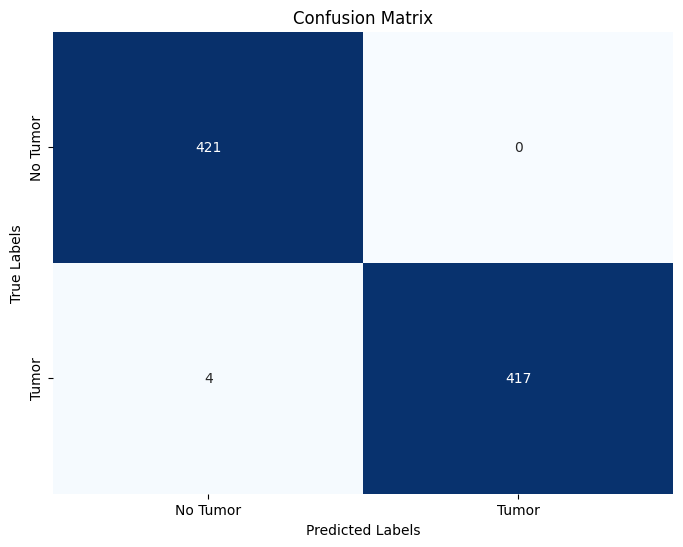

0.995249406175772


In [13]:
pred_labels = ensemble.predict(test_extracted_features)

cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels)

print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['No Tumor', 'Tumor'])
plt.yticks([0.5, 1.5], ['No Tumor', 'Tumor'])
plt.show()
print(accuracy_score(y_true=test_labels, y_pred=pred_labels))

In [14]:
file = open('/content/drive/MyDrive/CNN-XGBoost/CNNXGBoost.pickle', 'wb')
pickle.dump(ensemble, file)
file.close()